In [86]:
#!/usr/bin/python3.8

import subprocess
import matplotlib.pyplot as plot
import numpy
import sys
from optparse import OptionParser
import math
import copy
import random
# create estimation file
random.seed(1)
c_real = [[0,0,0],[2,0,math.pi/6]]

c0_vertex = [[1,-1,0], [1,0,0],[1,1,math.pi/4]]
c1_vertex = [[0,1,0], [-1,1,math.pi/6],[-1,0,math.pi/10]] # in frame 2
trans_data = ""
vertex_id = 0

c1_vertex_world = []
for vertex in c1_vertex:
    tmp = []
    theta = c_real[1][-1]
    tmp.append(math.cos(theta) * vertex[0] - math.sin(theta) * vertex[1] + c_real[1][0])
    tmp.append(math.sin(theta) * vertex[0] + math.cos(theta) * vertex[1] + c_real[1][1])
    tmp.append(theta + vertex[2])
    c1_vertex_world.append(tmp)

estimate_vertex = []
estimate_id = [[2,3,4],[5,6,7]]
for v1,v2 in zip(c0_vertex,c1_vertex_world):
    theta = v1[-1]
    tmp = []
    pos_x = v2[0] - v1[0]
    pos_y = v2[1] - v1[1]
    tmp.append(math.cos(theta) * pos_x + math.sin(theta) * pos_y )
    tmp.append(-math.sin(theta) * pos_x + math.cos(theta) * pos_y )
    tmp.append(v2[2] - v1[2])
    estimate_vertex.append(tmp)

c_real[1] = [0,0,0]
for center in c_real:
    trans_data+="VERTEX_SE2 {} {:.6f} {:.6f} {:.6f}\n".format(vertex_id,center[0],center[1],center[2])
    vertex_id +=1
for vertex in c0_vertex:
    trans_data+="VERTEX_SE2 {} {:.6f} {:.6f} {:.6f}\n".format(vertex_id,vertex[0],vertex[1],vertex[2])
    vertex_id +=1
for vertex in c1_vertex_world:
    trans_data+="VERTEX_SE2 {} {:.6f} {:.6f} {:.6f}\n".format(vertex_id,vertex[0],vertex[1],vertex[2])
    vertex_id +=1

#write edge
now_vertex = 2
trust = 1
for vertex in c0_vertex:
    trans_data+="EDGE_SE2 0 {} {:.6f} {:.6f} {:.6f} {:.6f} 0 0 {:.6f} 0 {:.6f}\n".format(now_vertex,vertex[0],vertex[1],vertex[2],trust,trust,trust)
    now_vertex +=1
now_vertex = 5
trust = 1
for vertex in c1_vertex:
    trans_data+="EDGE_SE2 1 {} {:.6f} {:.6f} {:.6f} {:.6f} 0 0 {:.6f} 0 {:.6f}\n".format(now_vertex,vertex[0],vertex[1],vertex[2],trust,trust,trust)
    now_vertex +=1

# write relative pose estimation
#need to add noisy
idx = 0
trust = 10000
for vertex in estimate_vertex:
    trans_data+="EDGE_SE2 {} {} {:.6f} {:.6f} {:.6f} {:.6f} 0 0 {:.6f} 0 {:.6f}\n".format(estimate_id[0][idx],estimate_id[1][idx],
    vertex[0] + random.uniform(-1, 1)/10,vertex[1]+ random.uniform(-1, 1)/10,vertex[2]+ random.uniform(-1, 1)/5,trust,trust,trust)
    idx +=1

process = subprocess.Popen("./pose_graph_2d", stdin=subprocess.PIPE, stdout=subprocess.PIPE, text=True)
# 向C++程序输入数据
process.stdin.write(trans_data)
# 关闭输入流
process.stdin.close()
output_data = process.stdout.read()
# 等待C++程序退出
process.wait()

output_data = output_data[:-1]

print(output_data)



0 0 0 0
1 2.01088 0.0185558 0.502119
2 0.994183 -1.00579 -0.0595098
3 1.03198 0.0220731 -0.0110852
4 0.973832 0.983715 0.83565
5 1.53541 0.900909 0.569592
6 0.621047 0.391765 1.01591
7 1.16048 -0.446446 0.725563


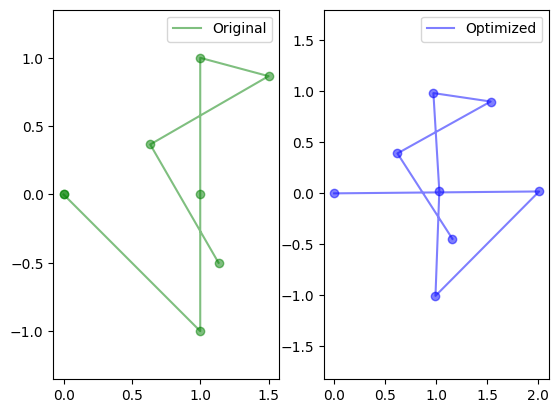

In [88]:
import matplotlib.pyplot as plot
import numpy as np
import sys

# Read the original and optimized poses files.
tmp = c_real + c0_vertex + c1_vertex_world
poses_original = np.array(tmp)

rows = output_data.split('\n')
# 将每行分割成字符串数组
data_list = [row.split() for row in rows]
# 将字符串数组转换为浮点数数组
data_arr = np.array(data_list, dtype=float)

poses_optimized = data_arr[:,1:-1]

# Plots the results for the specified poses.
plot.figure()
plot.subplot(121)
plot.plot(poses_original[:, 0], poses_original[:, 1], '-', label="Original",
            alpha=0.5, color="green")
plot.scatter(poses_original[:, 0], poses_original[:, 1],
alpha=0.5, color="green")
plot.axis('equal')
plot.legend()
plot.subplot(122)
plot.plot(poses_optimized[:, 0], poses_optimized[:, 1], '-', label="Optimized",
            alpha=0.5, color="blue")
plot.scatter(poses_optimized[:, 0], poses_optimized[:, 1],
            alpha=0.5, color="blue")
plot.axis('equal')
plot.legend()
# Show the plot and wait for the user to close.
plot.show()
